In [12]:
import pden
import pden.Net
import pden.Operations
import pden.PDENet

import tensorflow as tf

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from IPython.display import clear_output

%load_ext autoreload
%autoreload 1

%aimport pden.Net
%aimport pden.Operations
%aimport pden.PDENet

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
def der(y, x, y_shape: int, x_shape: int):
    ys = tf.split(y, [1] * y_shape, 1)
    def _der(i, j=[]):
        f = ys[i]
        for _j in j:
            fs = tf.gradients(f, x)[0]
            f  = tf.split(fs, [1] * x_shape, 1)[_j]        
        return f
    return _der

In [14]:
def div(y, x, y_shape: int, x_shape: int):
    der_gen = der(y, x, y_shape, x_shape)
    DIV = der_gen(0, j=[0])
    for i in range(1, x_shape):
        DIV += der_gen(0, j=[i])
    return DIV

def laplacian(y, x, y_shape: int, x_shape: int):
    der_gen = der(y, x, y_shape, x_shape)
    LAP = der_gen(0, j=[0, 0])
    for i in range(1, x_shape):
        LAP += der_gen(0, j=[i, i])
    return LAP

In [15]:
k = 8

net_1 = pden.Net.BasicNet(
    pden.Operations.Linear(feature_out=k, feature_in=1, random_init = True),
    pden.Operations.ActivationFunction(tf.nn.tanh),
    pden.Operations.Linear(feature_out=k, feature_in=k, random_init = True),
    pden.Operations.ActivationFunction(tf.nn.tanh)
)

net_2 = pden.Net.BasicNet(
    pden.Operations.Linear(feature_out=k, feature_in=1, random_init = True),
    pden.Operations.ActivationFunction(tf.nn.tanh),
    pden.Operations.Linear(feature_out=k, feature_in=k, random_init = True),
    pden.Operations.ActivationFunction(tf.nn.tanh)
)

net_3 = pden.Net.BasicNet(
    pden.Operations.Linear(feature_out=1, feature_in=k, random_init = True)
)

net_4 = pden.Net.BasicNet(
    pden.Operations.Linear(feature_out=k, feature_in=1, random_init = True),
    pden.Operations.ActivationFunction(tf.nn.tanh),
    pden.Operations.Linear(feature_out=k, feature_in=k, random_init = True),
    pden.Operations.ActivationFunction(tf.nn.tanh)
)

net_5 = pden.Net.BasicNet(
    pden.Operations.Linear(feature_out=k, feature_in=1, random_init = True),
    pden.Operations.ActivationFunction(tf.nn.tanh),
    pden.Operations.Linear(feature_out=k, feature_in=k, random_init = True),
    pden.Operations.ActivationFunction(tf.nn.tanh)
)

net_6 = pden.Net.BasicNet(
    pden.Operations.Linear(feature_out=1, feature_in=k, random_init = True)
)

pnet_u = pden.PDENet.HadamardNET(dimension_in=2, nets=[net_4, net_5, net_6], hidden=k)
pnet_v = pden.PDENet.HadamardNET(dimension_in=2, nets=[net_4, net_5, net_6], hidden=k)

print(net_1)
print(net_2)
print(net_3)

print(net_4)
print(net_5)
print(net_6)

Net 1:
	29	Linear: [1 -> 8]
	1	Activation funciton: <function tanh at 0x11b1a94d0>
	18	Linear: [8 -> 8]
	32	Activation funciton: <function tanh at 0x11b1a94d0>
Net 0:
	26	Linear: [1 -> 8]
	21	Activation funciton: <function tanh at 0x11b1a94d0>
	19	Linear: [8 -> 8]
	17	Activation funciton: <function tanh at 0x11b1a94d0>
Net 29:
	0	Linear: [8 -> 1]
Net 18:
	4	Linear: [1 -> 8]
	19	Activation funciton: <function tanh at 0x11b1a94d0>
	2	Linear: [8 -> 8]
	18	Activation funciton: <function tanh at 0x11b1a94d0>
Net 20:
	17	Linear: [1 -> 8]
	16	Activation funciton: <function tanh at 0x11b1a94d0>
	5	Linear: [8 -> 8]
	32	Activation funciton: <function tanh at 0x11b1a94d0>
Net 3:
	11	Linear: [8 -> 1]


In [16]:
x = tf.placeholder(tf.float64, [None, 2])
u = pnet_u.forward(x)
v = pnet_v.forward(x)

x0 = tf.placeholder(tf.float64, [None, 2])
u_x0 = pnet_u.forward(x0)
v_x0 = pnet_v.forward(x0)

y0 = tf.placeholder(tf.float64, [None, 2])
u_y0 = pnet_u.forward(y0)
v_y0 = pnet_v.forward(y0)

y1 = tf.placeholder(tf.float64, [None, 2])
u_y1 = pnet_u.forward(y1)
v_y1 = pnet_v.forward(y1)

x1 = tf.placeholder(tf.float64, [None, 2])
u_x1 = pnet_u.forward(x1)
v_x1 = pnet_v.forward(x1)

der_u_gen = der(u, x, 1, 2)
der_v_gen = der(v, x, 1, 2)

laplacian_u = laplacian(u, x, 1, 2)
laplacian_v = laplacian(v, x, 1, 2)

du_dx = der_u_gen(0, j=[0])
du_dy = der_u_gen(0, j=[1])
dv_dx = der_v_gen(0, j=[0])
dv_dy = der_v_gen(0, j=[1])

du_dxdy = der_u_gen(0, j=[0, 1])
dv_dydx = der_v_gen(0, j=[1, 0])
du_dxdx = der_u_gen(0, j=[0, 0])
du_dydy = der_u_gen(0, j=[1, 1])

dv_dxdx = der_v_gen(0, j=[0, 0])
dv_dydy = der_v_gen(0, j=[1, 1])

In [17]:
E = 1
nu= 0.3

lam = (E * nu) / ((1 + nu) * (1 - 2 * nu))
mu  = E / (2 + 2 * nu)

In [18]:
_x, _y = tf.split(x, [1, 1], 1)

In [19]:
f1 = (lam + mu) * (du_dxdx + dv_dydx) + mu * laplacian_u
f2 = (lam + mu) * (du_dxdy + dv_dydy) + mu * laplacian_v

pnet_u = pnet_u.add_loss(tf.reduce_mean(tf.pow(f1, 2)))
pnet_u = pnet_u.add_loss(tf.reduce_mean(tf.pow(f2, 2)))
pnet_u = pnet_u.add_loss(tf.reduce_mean(tf.pow(u_x0, 2)))
pnet_u = pnet_u.add_loss(tf.reduce_mean(tf.pow(v_x0, 2)))
pnet_u = pnet_u.add_loss(tf.reduce_mean(tf.pow(u_x1, 2)))
pnet_u = pnet_u.add_loss(tf.reduce_mean(tf.pow(v_x1, 2)))
pnet_u = pnet_u.add_loss(tf.reduce_mean(tf.pow(u_y0, 2)))
pnet_u = pnet_u.add_loss(tf.reduce_mean(tf.pow(v_y0, 2)))
pnet_u = pnet_u.add_loss(tf.reduce_mean(tf.pow(u_y1, 2)))
pnet_u = pnet_u.add_loss(tf.reduce_mean(tf.pow(v_y1 + 0.01, 2)))

pnet_v.loss = pnet_u.loss

In [20]:
learning_rate = 5e-3
training_epochs = 10001
display_step = 500

opt = tf.train.AdamOptimizer(learning_rate = learning_rate)
train = opt.minimize(pnet_u.loss)

init = tf.global_variables_initializer()

In [21]:
losses = []

In [22]:
sess = tf.Session()
sess.run(init)

for epoch in range(training_epochs):
    
    X = np.random.rand(100, 2)
    X0= np.random.rand(25, 2)
    X1= np.random.rand(25, 2)
    Y1= np.random.rand(25, 2)
    Y0= np.random.rand(25, 2)
    
    X0[:, 0] = 0
    X1[:, 0] = 1
    Y0[:, 1] = 0
    
    Y1[:, 1] = 1
    Y1[:, 0] = 0.5
    
    _, l = sess.run([train, pnet_u.loss], feed_dict={
        x: X,
        x0: X0,
        x1: X1,
        y0: Y0,
        y1: Y1
        
    })
    
    losses.append(np.log(l))
    
    if epoch % display_step == 0 and True:
        print(f'Training error for net is "{l}". Epoch {epoch}')

        
print("Optimization Finished!")

Training error for net is "380.73445791949695". Epoch 0
Training error for net is "0.04643335935189445". Epoch 500
Training error for net is "0.012539086187277032". Epoch 1000
Training error for net is "0.003648941412571858". Epoch 1500
Training error for net is "0.002470709688221969". Epoch 2000
Training error for net is "0.0014848826066329332". Epoch 2500
Training error for net is "0.000982237935671139". Epoch 3000
Training error for net is "0.0005417874917918801". Epoch 3500
Training error for net is "0.0003899212383000525". Epoch 4000
Training error for net is "0.00041505837811448346". Epoch 4500
Training error for net is "0.00030263610892807084". Epoch 5000
Training error for net is "0.00023835164555809486". Epoch 5500
Training error for net is "0.0077389453958069225". Epoch 6000
Training error for net is "0.00019709561638697114". Epoch 6500
Training error for net is "0.00022114925388997506". Epoch 7000
Training error for net is "0.0001272667467968484". Epoch 7500
Training error f

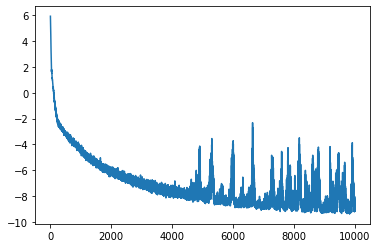

In [23]:
plt.plot(losses)

In [24]:
num = 25
_X = np.linspace(0, 1, num=num)
_X, _Y = np.meshgrid(_X, _X)

X = np.vstack((_X.flatten(), _Y.flatten())).T

U, V = sess.run([u, v], feed_dict={
    x: X
})

U = U.reshape((num, num))
V = V.reshape((num, num))

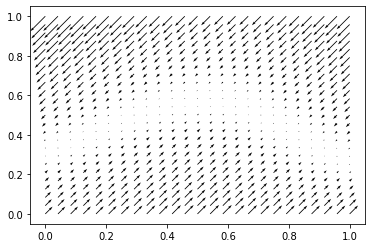

In [25]:
plt.quiver(_X, _Y, U, V)
plt.show()

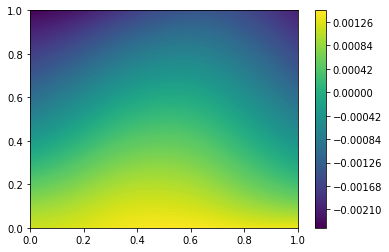

In [26]:
plt.contourf(_X, _Y, U, 150)
plt.colorbar()
plt.show()

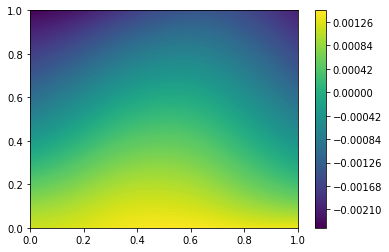

In [27]:
plt.contourf(_X, _Y, V, 150)
plt.colorbar()
plt.show()